Provide an alternative implementation of the PQK.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#needed to import qke procedures
import os
import sys
from pathlib import Path
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

#needed to import qke procedures
import sys
from pathlib import Path

main_dir = str(Path().resolve().parent)
sys.path.insert(1, main_dir)




In [3]:
#scikit learn and tools
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

#set the seed(s)
np.random.seed(123)
algorithm_globals.random_seed = 123

#load dataset with panda
#data are scaled outside the notebook
env = pd.read_csv('../data/env.sel3.scaled.csv') 
#take a look of the dataset

print(f'DESCRIBE DATASET')
display(env.describe() )


#DEFINE design matrix
#slice dataset
f_rate = 0.05
env_slice = env.sample(frac=f_rate, random_state=123)

Y = env_slice['occupancy']
#X = env[['illuminance', 'blinds','lamps','co', 'rh', 'co2', 'temp']]
X = env_slice[['illuminance', 'blinds','lamps','rh', 'co2', 'temp']]

print(f'HEAD')
display(X.head())

DESCRIBE DATASET


,illuminance,blinds,lamps,rh,co2,temp,occupancy
count,2.865000e+03,2865.000000,2865.000000,2865.000000,2.865000e+03,2.865000e+03,2865.000000
mean,-3.571314e-16,0.801622,0.596464,0.473229,-5.952190e-16,-7.142629e-16,-0.130192
std,1.000000e+00,0.372305,0.489316,0.080185,1.000000e+00,1.000000e+00,0.991662
min,-1.016287e+00,0.000000,0.000000,0.243300,-1.222685e+00,-1.774534e+00,-1.000000
25%,-8.575745e-01,1.000000,0.000000,0.433700,-8.492006e-01,-8.538436e-01,-1.000000
50%,-6.989177e-02,1.000000,1.000000,0.491100,-3.252814e-01,-1.940149e-01,-1.000000
75%,3.357060e-01,1.000000,1.000000,0.524100,7.569402e-01,7.266751e-01,1.000000
max,8.559349e+00,1.000000,1.000000,0.633300,3.583699e+00,2.614091e+00,1.000000


HEAD


,illuminance,blinds,lamps,rh,co2,temp
1618,-0.064014,1.0,1.0,0.5112,0.513679,-0.894763
610,1.552499,1.0,1.0,0.3178,-0.802352,0.992653
1667,-0.969261,1.0,0.0,0.5350,0.115264,-0.853844
2481,-0.134552,0.0,1.0,0.5418,0.601788,-1.421603
2638,-0.434342,1.0,0.0,0.5088,0.469415,-0.587866


In [4]:
#split design matrix (25% of the design matrix used for test)
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=123)

#cast to numpy object
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

NUM_QUBIT =  X_train.shape[1]
#sanity check
print(f'TRAIN***** {X_train.shape}')
print(f'TEST***** {X_test.shape}')
print(f'Number of Qbit:  {NUM_QUBIT}')

TRAIN***** (107, 6)
TEST***** (36, 6)
Number of Qbit:  6


Define my feature map

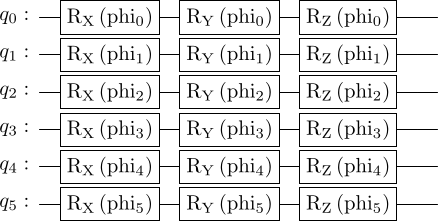

In [5]:
#get the feature mao
from pqk.Circuits import Circuits

fm = Circuits.xyz_encoded(n_wire=NUM_QUBIT, full_ent=False)

display(fm.draw('latex'))

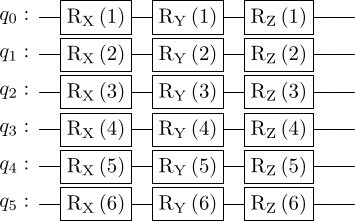

In [6]:
#try data encoding
from pqk.CircuitContainer import CircuitContainer

data_to_encode = np.array([1,2,3,4,5,6])

fm_encoded = CircuitContainer.qEncoding(qc=fm, data=data_to_encode)

fm_encoded.draw('latex')

Define the function for PQK

In [7]:
#define a set of observables
#my_obs = ['XIIIII', 'IXIIII','IIXIII', 'IIIXII','IIIIXI','IIIIIX','YIIIII', 'IYIIII','IIYIII', 'IIIYII','IIIIYI','IIIIIY','ZIIIII', 'IZIIII','IIZIII', 'IIIZII','IIIIZI','IIIIIZ']
#my_obs = ['XIIIII', 'IXIIII','IIXIII', 'IIIXII','IIIIXI','IIIIIX']
my_obs = ['YIIIII', 'IYIIII','IIYIII', 'IIIYII','IIIIYI','IIIIIY']
#my_obs = ['ZIIIII', 'IZIIII','IIZIII', 'IIIZII','IIIIZI','IIIIIZ']

In [9]:
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import SparsePauliOp
from pqk.CircuitContainer import CircuitContainer

# First we can create a circuit to calculate the feature map 
def projected_q_feature_map(x):   


    res = []

    #　Take a projected measurement, returning its expected value as a classical feature
    for op_pauli in my_obs:

        estimator = StatevectorEstimator(default_precision=0)             

        obs =  SparsePauliOp(op_pauli)

        fm_encoded = CircuitContainer.qEncoding(qc=fm, data=x)

        pub = (fm_encoded, obs)
        job = estimator.run([pub])
        result = job.result()[0]
        res.append(result.data.evs)
    return res

In [10]:
p_feature_vector_1 = np.array(projected_q_feature_map([1,2,3,4,5,6]))
p_feature_vector_2 = np.array(projected_q_feature_map([7,8,9,10,11,12]))

display(p_feature_vector_1)
display(p_feature_vector_2)

array([ 0.34324985,  0.53284808, -0.86905352,  0.11999219,  0.03432197,
       -0.07207501])

array([ 0.69574359,  0.00885127, -0.70480337,  0.22074576,  0.0015319 ,
       -0.1698958 ])

In [11]:
#gaussian kernel in alternative implementation
from pqk.CKernels import CKernels


alterantive_1 = np.exp(-((p_feature_vector_1 - p_feature_vector_2) ** 2).sum())

alterantive_2 = CKernels.rbf(x=p_feature_vector_1, y=p_feature_vector_2, gamma=1)

print(alterantive_1)
print(alterantive_2)

check_ok = alterantive_1 == alterantive_2
if check_ok:
    print('PQK implementation is ok')
else:
    print('Some things go wrong in our PQK implementation')





0.639801065972342
0.639801065972342
PQK implementation is ok
